In [2]:
# ! pip install pycaret

In [3]:
# ! pip install --upgrade networkx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def history_presentation(sides, outputs):

    """
    sides : np.array of the sides where the stimulus was presented (-1: Left, 1: right)
    outputs : np.array of the outputs (0: incorrect, 1: correct)
    """
    reinforced = sides * outputs
    punished = sides * (1 - outputs)

    return(np.sum(reinforced - punished))


def history_decision(decisions, outputs):

    """
    decisions : np.array of the decisions where the stimulus was presented (-1: Left, 1: right)
    outputs : np.array of the outputs (0: incorrect, 1: correct)
    """
    reinforced = decisions * outputs
    punished = decisions * (1 - outputs)

    return(np.sum(reinforced - punished))


def bias(sides):
    """
    sides : np.array of the sides where the stimulus was presented (-1: Left, 1: right)
    """

    return(np.mean(sides))


In [6]:
class IBLTrialDataset:
    
    def __init__(self, features=['sides', 'history_presentation', 'history_decision', 'bias', 'signed_contrast'], session='all', contrast_th = 1., left_prob = None):
        
        self.features = features
        self.session = session
        self.contrast_th = contrast_th
        self.left_prob = left_prob

    @staticmethod
    def apply_hist_per_subject(x, func, window_size=1):
        """
        Applies function (func) on dataframe (x) in given window (wind) after groupBy per subject.

        x: pd.DataFrame: (N, n_cols [1 or 2]) - two or one-column dataframe with values need to run function
        window_size: int - numer of trials in history

        """
        x = x.values
        result = np.zeros(x.shape[0])
        if x.ndim > 1:
            padded = np.vstack([np.zeros((window_size, x.shape[-1])), x])
            for i in range(window_size, padded.shape[0]):
                x1, x2 = padded[i-window_size: i, 0], padded[i-window_size: i, 1]
                result[i-window_size] = func(x1, x2)
        else:
            padded = np.concatenate([np.zeros(window_size), x])
            for i in range(window_size, padded.shape[0]):
                x1 = padded[i-window_size: i]
                result[i-window_size] = func(x1)
        res = pd.DataFrame(result)

        return pd.DataFrame(result)


    def create_dataset(self, df, window_size):
        """
        Creates dataset as model input (X,y)

        df: pd.DataFrame - input data frame
        window_size: int - window_size of history trials

        output:
        X: np.array(N, num_features) - transformed dataset of features that can be an input to the model
        y: np.array(N,) - numpy array of choices true choices
        """

        df.sort_values(by=['session_start_time', 'trial_id'], inplace=True) # to make sure we're sorted for the grouping later on

        # ground truth stimuli sides
        df['sides'] = df['signed_contrast']
        df.loc[df.sides > 0, 'sides'] = 1
        df.loc[df.sides < 0, 'sides'] = -1
        
        # the actual mice response to the stimuli
        # TODO: verify !
        df.loc[df.trial_response_choice == 'No Go'] = 0
        df.loc[df.trial_response_choice == 'CCW', 'trial_response_choice'] = 1
        df.loc[df.trial_response_choice == 'CW', 'trial_response_choice'] = -1
        
        df.trial_response_choice = df.trial_response_choice.astype('float')

        # derive a column for correct answers
        df['correct'] = df.trial_response_choice == df.sides
        df['correct'] = df['correct'].astype('float')
        
        if 'history_presentation' in self.features:

#         # get history presentation per trial
            df['history_presentation'] = (df.groupby('subject_uuid')['sides', 'correct'].apply(lambda x: self.apply_hist_per_subject(x, history_presentation, window_size)).reset_index()).iloc[:, -1]
    
        if 'history_decision' in self.features:
        # get history decision per trial
            df['history_decision'] = (df.groupby('subject_uuid')['trial_response_choice', 'correct'].apply(lambda x: self.apply_hist_per_subject(x, history_decision, window_size)).reset_index()).iloc[:, -1]

        if 'bias' in self.features:
        # get bias history per trial
            df['bias'] = (df.groupby('subject_uuid')['sides'].apply(lambda x: self.apply_hist_per_subject(x, bias, window_size)).reset_index()).iloc[:, -1]

        # drop NO GO 
        df = df.loc[df.trial_response_choice != 0.0]
        
        if self.session in ('biased', 'ephys'):
            df = df[df.task_protocol.str.contains(self.session)]
            
        if self.left_prob != None:
            df = df.loc[df.trial_stim_prob_left == self.left_prob]
            
        #filter the stimulus strength
        df = df.loc[df.signed_contrast.abs() <= self.contrast_th]
        
                    
        X, y = df[self.features], df['trial_response_choice']
        
        
        return X, y


In [7]:
##### TO CHANGE DEPENDING ON YOUR PATH
data_df = pd.read_csv('/home/a103/Documents/GitHub/Neuromatch_IBL/ibl_dataframe_fully_trained_mice_w_status_protocol_wo_nogo.csv')

ds = IBLTrialDataset(session='biased', left_prob = 0.5)
X, y = ds.create_dataset(data_df, window_size = 10)

/tmp/ipykernel_17305/1743115497.py:70: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df['history_presentation'] = (df.groupby('subject_uuid')['sides', 'correct'].apply(lambda x: self.apply_hist_per_subject(x, history_presentation, window_size)).reset_index()).iloc[:, -1]
/tmp/ipykernel_17305/1743115497.py:74: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df['history_decision'] = (df.groupby('subject_uuid')['trial_response_choice', 'correct'].apply(lambda x: self.apply_hist_per_subject(x, history_decision, window_size)).reset_index()).iloc[:, -1]


In [8]:
# just a validation
type(X)
X.head()

,sides,history_presentation,history_decision,bias,signed_contrast
1425466,-1.0,0.0,8.0,0.6,-0.1250
1425467,1.0,0.0,6.0,0.4,0.0625
1425468,-1.0,2.0,8.0,0.6,-0.2500
1425469,1.0,2.0,6.0,0.4,0.2500
1425470,1.0,4.0,6.0,0.4,0.2500


In [9]:
from pycaret.classification import *

In [10]:
# setting up experiments with pre-processing activiites, including specification of CV and missing value handling
s = setup(data = X, target = y, session_id=2607)

,Description,Value
0,Session id,2607
1,Target,trial_response_choice
2,Target type,Binary
3,Target mapping,"-1.0: 0, 1.0: 1"
4,Original data shape,"(278303, 6)"
5,Transformed data shape,"(278303, 6)"
6,Transformed train set shape,"(194812, 6)"
7,Transformed test set shape,"(83491, 6)"
8,Numeric features,5
9,Preprocess,True


In [11]:
# create logistic regression model
logistic_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8060,0.8820,0.8097,0.8053,0.8075,0.6120,0.6120
1,0.8002,0.8757,0.8147,0.7933,0.8039,0.6004,0.6006
2,0.8069,0.8825,0.8139,0.8043,0.8091,0.6138,0.6139
3,0.7944,0.8716,0.7984,0.7937,0.7960,0.5888,0.5888
4,0.8038,0.8788,0.8128,0.7999,0.8063,0.6075,0.6076
5,0.8022,0.8781,0.8048,0.8023,0.8035,0.6044,0.6044
6,0.8048,0.8810,0.8072,0.8050,0.8061,0.6097,0.6097
7,0.8041,0.8793,0.8077,0.8035,0.8056,0.6081,0.6081
8,0.8059,0.8813,0.8086,0.8059,0.8072,0.6118,0.6118


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

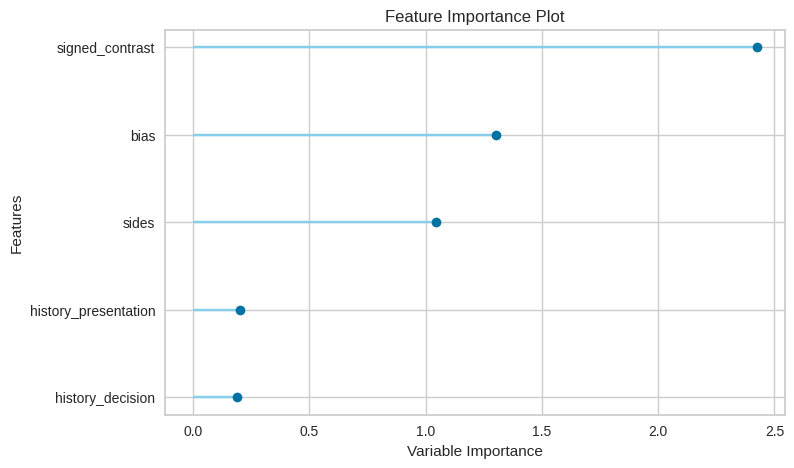

In [12]:
# relative importance of variables in un-tuned LR model
plot_model(logistic_model, plot = 'feature')


In [13]:
# tuning of hyperparameters
tuned_logistic = tune_model(logistic_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8059,0.8820,0.8042,0.8085,0.8063,0.6117,0.6118
1,0.8008,0.8757,0.8104,0.7968,0.8035,0.6016,0.6017
2,0.8065,0.8825,0.8083,0.8070,0.8076,0.6129,0.6129
3,0.7954,0.8716,0.7949,0.7973,0.7961,0.5908,0.5908
4,0.8036,0.8788,0.8087,0.8020,0.8054,0.6071,0.6071
5,0.8019,0.8781,0.8007,0.8042,0.8024,0.6037,0.6037
6,0.8056,0.8810,0.8028,0.8090,0.8058,0.6112,0.6112
7,0.8036,0.8793,0.8021,0.8060,0.8041,0.6071,0.6071
8,0.8058,0.8813,0.8032,0.8090,0.8061,0.6116,0.6116


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [14]:
# see the tuned LR model
tuned_logistic

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2607, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

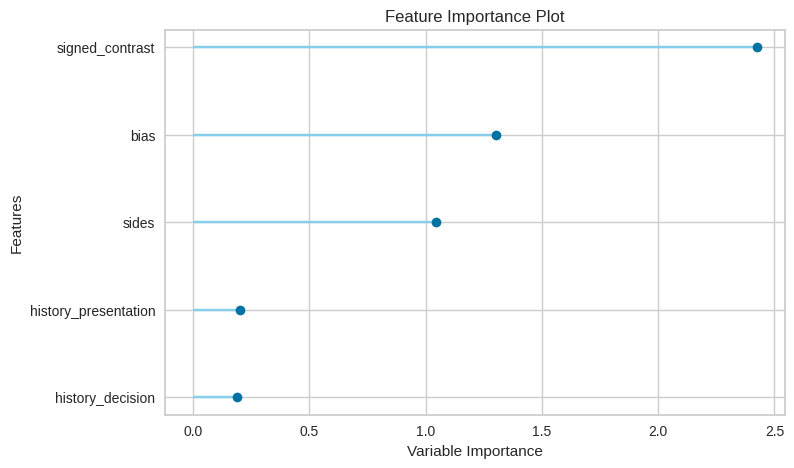

In [15]:
# relative importance of variables in tuned LR model
plot_model(tuned_logistic, plot = 'feature')

In [16]:
# create random forest model
rf_model = create_model('rf')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8044,0.8829,0.8030,0.8069,0.8049,0.6089,0.6089
1,0.7977,0.8768,0.8060,0.7944,0.8002,0.5954,0.5954
2,0.8036,0.8818,0.8013,0.8066,0.8040,0.6072,0.6072
3,0.7945,0.8745,0.7952,0.7957,0.7954,0.5889,0.5889
4,0.7977,0.8803,0.8043,0.7954,0.7998,0.5954,0.5954
5,0.8010,0.8794,0.7972,0.8050,0.8011,0.6021,0.6021
6,0.8034,0.8821,0.8000,0.8072,0.8036,0.6069,0.6069
7,0.7997,0.8809,0.7964,0.8033,0.7999,0.5994,0.5994
8,0.8037,0.8823,0.7974,0.8092,0.8033,0.6074,0.6075


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
# tuning of hyperparameters
tuned_rf = tune_model(rf_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7896,0.8695,0.7737,0.8008,0.7871,0.5793,0.5796
1,0.7828,0.8641,0.7739,0.7897,0.7817,0.5656,0.5657
2,0.7906,0.8714,0.7816,0.7976,0.7895,0.5812,0.5813
3,0.7765,0.8597,0.7598,0.7879,0.7736,0.5531,0.5534
4,0.7838,0.8665,0.7610,0.7992,0.7796,0.5677,0.5683
5,0.7866,0.8662,0.7700,0.7983,0.7839,0.5733,0.5737
6,0.7910,0.8700,0.7787,0.8001,0.7892,0.5820,0.5822
7,0.7855,0.8677,0.7720,0.7952,0.7835,0.5711,0.5714
8,0.7879,0.8685,0.7699,0.8005,0.7849,0.5760,0.5764


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [18]:
# see the tuned RF model
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2607, verbose=0, warm_start=False)

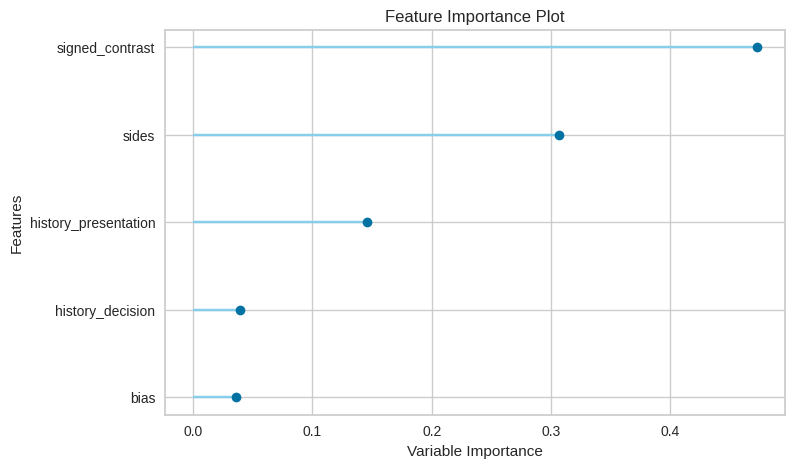

In [19]:
# relative importance of variables in un-tuned RF model
plot_model(rf_model, plot = 'feature')


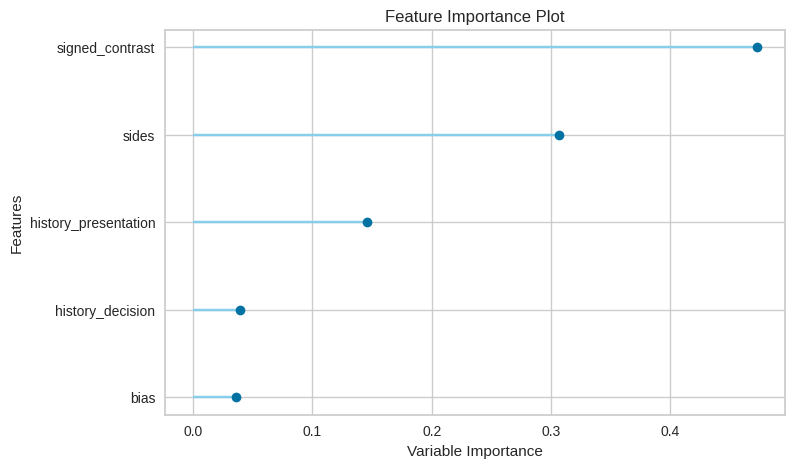

In [20]:
# relative importance of variables in tuned RF model
plot_model(tuned_rf, plot = 'feature')

In [21]:
# importance of variables 
rf_model.feature_importances_

array([0.30638447, 0.14531927, 0.03969188, 0.0363414 , 0.47226298])

In [22]:
#save models
save_model(tuned_logistic, 'my_first_pipeline_lr')
save_model(tuned_rf, 'my_first_pipeline_rf')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['sides', 'history_presentation',
                                              'history_decision', 'bias',
                                              'signed_contrast'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=Tr...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='auto',
                                         max_leaf_nodes=None, ma

In [24]:
# compare models for different classifiers

compare_tree_models = compare_models(include = [tuned_logistic, tuned_rf])

# Above function above has return trained model object as an output. 
# The scoring grid is only displayed and not returned. 
# If you need access to the scoring grid you can use pull function to access the dataframe.
compare_tree_models_results = pull()
compare_tree_models_results


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.8032,0.8791,0.8085,0.8016,0.8050,0.6064,0.6064,0.0490
1,Random Forest Classifier,0.8008,0.8803,0.8001,0.8029,0.8015,0.6017,0.6017,0.2240


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.8032,0.8791,0.8085,0.8016,0.8050,0.6064,0.6064,0.049
1,Random Forest Classifier,0.8008,0.8803,0.8001,0.8029,0.8015,0.6017,0.6017,0.224
